### This notebook tries to quantify what statistics matter in an NBA player's Hall of Fame candidacy.

### In this notebook, we will import a dataset from Kaggle, scrape data responsibly from basketball reference, utilize duckdb to manipulate and join our data, model our data with random forests and decision trees, and lastly predict who in today's NBA will make the Hall of Fame

In [1]:
import numpy as np
import pandas as pd
import os

# Importing Kaggle datasets

In [5]:
#https://www.kaggle.com/datasets/justinas/nba-players-data
player_df = pd.read_csv("all_seasons.csv")

In [6]:
player_df.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


# Scraping data from basketball reference

In [7]:
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import time

In [8]:
tables = {}
def scrape_table(endpoint):
    headers = {'User-Agent': 'Mozilla/5.0'}
    url = 'https://www.basketball-reference.com/awards/' + endpoint + '.html'
    response = requests.get(url, headers)
    if(response.status_code != 200):
        print(endpoint + " : failed")
        
    soup = BeautifulSoup(response.content, 'html.parser')
    stat_table = soup.find_all('table')
    
    #starting out index 1 b/c the first row of bball-reference tables are most of the time column spans
    column_headers = stat_table[0].findAll('tr')[1]
    column_headers = [i.getText() for i in column_headers.findAll('th')]
    
    rows = stat_table[0].findAll('tr')[2:]
    stats_list = []
    for i in range(len(rows)):
        stats_list.append([col.getText() for col in rows[i].findAll('td')])
        
    # Create DataFrame from our scraped data
    tables[endpoint] = pd.DataFrame(stats_list, columns=column_headers[1:])
    tables[endpoint] = tables[endpoint].dropna()
    
    print(endpoint + " : successful")

## Looping through bball reference

In [9]:
headers = {'User-Agent': 'Mozilla/5.0'}
url = 'https://www.basketball-reference.com/awards/'
response = requests.get(url, headers)
if(response.status_code != 200):
    print(response.status_code)
    print("Can't go to awards page")

soup = BeautifulSoup(response.content, 'html.parser')

for i in soup.find_all('a'):
    if "/awards/" in i['href'] and "awards_" not in i['href'] and ".html" in i['href']:
        try:
            scrape_table(i['href'][8:-5])
        except:
            print("unable to parse : " + i['href'][8:-5])
            
        time.sleep(5)

hof : successful
mvp : successful
roy : successful
dpoy : successful
smoy : successful
mip : successful
tmoy : successful
citizenship : successful
finals_mvp : successful
playoffs_mvp : successful
wcf_mvp : successful
ecf_mvp : successful
all_star_mvp : successful
cpoy : successful
player_of_the_seeding_games : successful
tsn_mvp : successful
tsn_roy : successful
hustle : successful
social_justice : successful
sportsmanship : successful
ist_mvp : successful
clutch_poy : successful
unable to parse : coy
unable to parse : nbca_coy
unable to parse : eoy
reg_rec : successful
unable to parse : pom
unable to parse : rom
unable to parse : com
unable to parse : pow
unable to parse : all_league
leading_all_nba : successful
unable to parse : all_rookie
unable to parse : all_defense
unable to parse : all_seeding_games
ist_all_tournament : successful
nba_75th_anniversary : successful
nba_top_15_coaches : successful
nba_50_greatest : successful
nba_top_10_coaches : successful
nba_35th_anniversary :

In [10]:
tables.keys()

dict_keys(['hof', 'mvp', 'roy', 'dpoy', 'smoy', 'mip', 'tmoy', 'citizenship', 'finals_mvp', 'playoffs_mvp', 'wcf_mvp', 'ecf_mvp', 'all_star_mvp', 'cpoy', 'player_of_the_seeding_games', 'tsn_mvp', 'tsn_roy', 'hustle', 'social_justice', 'sportsmanship', 'ist_mvp', 'clutch_poy', 'reg_rec', 'leading_all_nba', 'ist_all_tournament', 'nba_75th_anniversary', 'nba_top_15_coaches', 'nba_50_greatest', 'nba_top_10_coaches', 'nba_35th_anniversary', 'nba_silver_anniversary', 'slam_500_greatest', 'simmons_pyramid', 'aba_all_time_team', 'ap_poy', 'wooden', 'naismith', 'recruit_rankings_2024', 'uso'])

# Master database

In [216]:
import duckdb

In [217]:
master_df = duckdb.sql('''
    SELECT player_name, 
        COUNT(team_abbreviation) as num_teams,
        MAX(player_height) as player_height,
        AVG(player_weight) as player_weight,
        MAX(college) as college,
        MAX(country) as country,
        MAX(draft_year) as draft_year,
        MAX(draft_round) as draft_round,
        MAX(draft_number) as draft_number,
        AVG(gp) as avg_gp,
        MAX(gp) as max_gp,
        SUM(gp) as tot_gp,
        SUM(pts) as tot_pts,
        AVG(pts) as avg_pts,
        MAX(pts) as max_pts,
        AVG(reb) as avg_reb,
        SUM(reb) as tot_reb,
        MAX(reb) as max_reb,
        MAX(ast) as max_ast,
        AVG(ast) as avg_ast,
        SUM(ast) as tot_ast,
        MAX(net_rating) as max_nr,
        AVG(net_rating) as avg_nr,
        MAX(oreb_pct) as max_oreb_pct,
        AVG(oreb_pct) as avg_oreb_pct,
        MAX(dreb_pct) as max_dreb_pct,
        AVG(dreb_pct) as avg_dreb_pct,
        MAX(usg_pct) as max_usg_pct,
        AVG(usg_pct) as avg_usg_pct,
        MAX(ts_pct) as max_ts_pct,
        AVG(ts_pct) as avg_ts_pct,
        MAX(ast_pct) as max_ast_pct,
        AVG(ast_pct) as avg_ast_pct,
        COUNT(season) as num_seasons
    FROM player_df
    GROUP BY player_name
''')

In [218]:
duckdb.sql('''SELECT * FROM master_df LIMIT 5''')

┌──────────────────┬───────────┬───────────────┬───┬─────────────┬──────────────────────┬─────────────┐
│   player_name    │ num_teams │ player_height │ … │ max_ast_pct │     avg_ast_pct      │ num_seasons │
│     varchar      │   int64   │    double     │   │   double    │        double        │    int64    │
├──────────────────┼───────────┼───────────────┼───┼─────────────┼──────────────────────┼─────────────┤
│ Gheorghe Muresan │         3 │        231.14 │ … │       0.056 │  0.02666666666666667 │           3 │
│ Glen Rice        │        10 │         203.2 │ … │       0.151 │  0.09829999999999998 │          10 │
│ Greg Ostertag    │        10 │        218.44 │ … │       0.122 │ 0.054200000000000005 │          10 │
│ Harvey Grant     │         3 │        205.74 │ … │       0.067 │ 0.057999999999999996 │           3 │
│ Elliot Perry     │         6 │        182.88 │ … │       0.389 │   0.2906666666666667 │           6 │
├──────────────────┴───────────┴───────────────┴───┴────────────

## Joining hof data

In [219]:
tables['hof'].head()

,Name,Category,G,PTS,TRB,AST,STL,BLK,FG%,3P%,...,WS,WS/48,,G,W,L,W/L%,name_arr,player_name,hof
0,Seimone Augustus WNBA / Int'l / CBB player,Player,,,,,,,,,...,,,,,,,,"[Seimone, Augustus, WNBA, /, Int'l, /, CBB, pl...",Seimone Augustus,1
1,Dick Barnett Player / Coach,Player,971,15.8,2.9,2.8,0.2,0.0,.456,,...,68.7,.114,,,,,,"[Dick, Barnett, Player, /, Coach]",Dick Barnett,1
2,Chauncey Billups Player / Coach / Int'l / CB...,Player,1043,15.2,2.9,5.4,1.0,0.2,.415,.387,...,120.8,.176,,,,,,"[Chauncey, Billups, Player, /, Coach, /, Int'l...",Chauncey Billups,1
3,Vince Carter Player / Int'l / CBB player,Player,1541,16.7,4.3,3.1,1.0,0.6,.435,.371,...,125.3,.130,,,,,,"[Vince, Carter, Player, /, Int'l, /, CBB, player]",Vince Carter,1
4,Doug Collins Player / Coach / Exec / Int'l /...,Contributor,,,,,,,,,...,,,,,,,,"[Doug, Collins, Player, /, Coach, /, Exec, /, ...",Doug Collins,1


In [220]:
hof_df = tables['hof']
hof_df['name_arr'] = hof_df['Name'].map(lambda s: s.split())
hof_df['player_name'] = hof_df['name_arr'].map(lambda s: s[0] + " " + s[1])
hof_df['hof'] = 1
hof_df.head()

,Name,Category,G,PTS,TRB,AST,STL,BLK,FG%,3P%,...,WS,WS/48,,G,W,L,W/L%,name_arr,player_name,hof
0,Seimone Augustus WNBA / Int'l / CBB player,Player,,,,,,,,,...,,,,,,,,"[Seimone, Augustus, WNBA, /, Int'l, /, CBB, pl...",Seimone Augustus,1
1,Dick Barnett Player / Coach,Player,971,15.8,2.9,2.8,0.2,0.0,.456,,...,68.7,.114,,,,,,"[Dick, Barnett, Player, /, Coach]",Dick Barnett,1
2,Chauncey Billups Player / Coach / Int'l / CB...,Player,1043,15.2,2.9,5.4,1.0,0.2,.415,.387,...,120.8,.176,,,,,,"[Chauncey, Billups, Player, /, Coach, /, Int'l...",Chauncey Billups,1
3,Vince Carter Player / Int'l / CBB player,Player,1541,16.7,4.3,3.1,1.0,0.6,.435,.371,...,125.3,.130,,,,,,"[Vince, Carter, Player, /, Int'l, /, CBB, player]",Vince Carter,1
4,Doug Collins Player / Coach / Exec / Int'l /...,Contributor,,,,,,,,,...,,,,,,,,"[Doug, Collins, Player, /, Coach, /, Exec, /, ...",Doug Collins,1


In [221]:
master_df = duckdb.sql('''
    SELECT * 
    FROM master_df 
    LEFT JOIN (SELECT player_name AS pn, hof FROM hof_df) AS hof_df
    ON master_df.player_name = hof_df.pn
''')
master_df = duckdb.sql('''
    SELECT
        *,
        CASE
          WHEN hof=1 THEN 1
        ELSE
          0
        END AS hof_bin
    FROM master_df
''')

In [222]:
duckdb.sql('''SELECT * FROM master_df LIMIT 5''')

┌──────────────────┬───────────┬───────────────┬────────────────────┬───┬─────────────┬─────────┬───────┬─────────┐
│   player_name    │ num_teams │ player_height │   player_weight    │ … │ num_seasons │   pn    │  hof  │ hof_bin │
│     varchar      │   int64   │    double     │       double       │   │    int64    │ varchar │ int64 │  int32  │
├──────────────────┼───────────┼───────────────┼────────────────────┼───┼─────────────┼─────────┼───────┼─────────┤
│ Gheorghe Muresan │         3 │        231.14 │         137.438376 │ … │           3 │ NULL    │  NULL │       0 │
│ Glen Rice        │        10 │         203.2 │  98.88305600000001 │ … │          10 │ NULL    │  NULL │       0 │
│ Greg Ostertag    │        10 │        218.44 │ 127.00575999999998 │ … │          10 │ NULL    │  NULL │       0 │
│ Harvey Grant     │         3 │        205.74 │           102.0582 │ … │           3 │ NULL    │  NULL │       0 │
│ Elliot Perry     │         6 │        182.88 │          69.399576 │ … 

## Joining MVP

In [223]:
mvp_df = tables['mvp']
mvp_df.head()

,Lg,Player,Voting,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,NBA,Nikola Jokić,(V),28,DEN,79,34.6,26.4,12.4,9.0,1.4,0.9,.583,.359,.817,17.0,.299
1,NBA,Joel Embiid,(V),28,PHI,66,34.6,33.1,10.2,4.2,1.0,1.7,.548,.330,.857,12.3,.259
2,NBA,Nikola Jokić,(V),26,DEN,74,33.5,27.1,13.8,7.9,1.5,0.9,.583,.337,.810,15.2,.296
3,NBA,Nikola Jokić,(V),25,DEN,72,34.6,26.4,10.8,8.3,1.3,0.7,.566,.388,.868,15.6,.301
4,NBA,Giannis Antetokounmpo,(V),25,MIL,63,30.4,29.5,13.6,5.6,1.0,1.0,.553,.304,.633,11.1,.279


In [224]:
mvp_df = duckdb.sql('''
    SELECT 
        Player,
        COUNT(*) as mvps
    FROM mvp_df
    GROUP BY Player
''')

In [225]:
master_df = duckdb.sql('''
    SELECT * 
    FROM master_df 
    LEFT JOIN mvp_df
    ON master_df.player_name = mvp_df.Player
''')
master_df = duckdb.sql('''
    SELECT
        *,
        CASE
          WHEN mvps>0 THEN mvps
        ELSE
          0
        END AS num_mvps
    FROM master_df
''')

In [226]:
duckdb.sql('''
    SELECT * FROM master_df LIMIT 5
''')

┌──────────────────┬───────────┬───────────────┬────────────────────┬───┬─────────┬─────────┬───────┬──────────┐
│   player_name    │ num_teams │ player_height │   player_weight    │ … │ hof_bin │ Player  │ mvps  │ num_mvps │
│     varchar      │   int64   │    double     │       double       │   │  int32  │ varchar │ int64 │  int64   │
├──────────────────┼───────────┼───────────────┼────────────────────┼───┼─────────┼─────────┼───────┼──────────┤
│ Gaylon Nickerson │         1 │         190.5 │           86.18248 │ … │       0 │ NULL    │  NULL │        0 │
│ Elmer Bennett    │         1 │        182.88 │           77.11064 │ … │       0 │ NULL    │  NULL │        0 │
│ Eric Murdock     │         4 │        185.42 │  87.31645999999999 │ … │       0 │ NULL    │  NULL │        0 │
│ Eric Piatkowski  │        12 │        200.66 │  97.59787866666666 │ … │       0 │ NULL    │  NULL │        0 │
│ Herb Williams    │         3 │        210.82 │ 115.21236800000001 │ … │       0 │ NULL    │  N

## Looping through tables

In [227]:
awards = ['roy', 'dpoy', 'smoy', 'mip', 'tmoy', 'citizenship', 'finals_mvp', 'playoffs_mvp', 
          'wcf_mvp', 'ecf_mvp', 'all_star_mvp', 'cpoy', 'player_of_the_seeding_games', 'tsn_mvp', 
          'tsn_roy', 'hustle', 'social_justice', 'sportsmanship', 'ist_mvp', 'clutch_poy', 'reg_rec', 
          'leading_all_nba', 'ist_all_tournament','ap_poy', 'wooden', 'naismith','uso']

In [228]:
def join_awards_table(award_name):
    df = tables[award_name]
    
    df = duckdb.sql(f'''
        SELECT 
            Player,
            COUNT(*) as {award_name}
        FROM mvp_df
        GROUP BY Player
    ''')
    
    master_df = duckdb.sql('''
        SELECT * 
        FROM master_df 
        LEFT JOIN df
        ON master_df.player_name = df.Player
    ''')
    master_df = duckdb.sql(f'''
        SELECT
            *,
            CASE
              WHEN {award_name}>0 THEN {award_name}
            ELSE
              0
            END AS num_{award_name}
        FROM master_df
    ''')
    return master_df

In [229]:
for i in awards:
    try:
        master_df = join_awards_table(i)
        print(f'successfully joined {i}')
    except:
        print(f"failed to join {i}")

successfully joined roy
successfully joined dpoy
successfully joined smoy
successfully joined mip
successfully joined tmoy
successfully joined citizenship
successfully joined finals_mvp
successfully joined playoffs_mvp
successfully joined wcf_mvp
successfully joined ecf_mvp
successfully joined all_star_mvp
successfully joined cpoy
successfully joined player_of_the_seeding_games
successfully joined tsn_mvp
successfully joined tsn_roy
successfully joined hustle
successfully joined social_justice
successfully joined sportsmanship
successfully joined ist_mvp
successfully joined clutch_poy
successfully joined reg_rec
successfully joined leading_all_nba
successfully joined ist_all_tournament
successfully joined ap_poy
successfully joined wooden
successfully joined naismith
successfully joined uso


# Reducing dataset

In [230]:
master_df = duckdb.sql('SELECT * FROM master_df').df()

In [231]:
master_df = master_df.dropna(axis=1)

In [232]:
master_df.head()

,player_name,num_teams,player_height,player_weight,college,country,draft_year,draft_round,draft_number,avg_gp,...,num_sportsmanship,num_ist_mvp,num_clutch_poy,num_reg_rec,num_leading_all_nba,num_ist_all_tournament,num_ap_poy,num_wooden,num_naismith,num_uso
0,Gaylon Nickerson,1,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,34,4.000000,...,0,0,0,0,0,0,0,0,0,0
1,Elmer Bennett,1,182.88,77.110640,Notre Dame,USA,1992,2,38,9.000000,...,0,0,0,0,0,0,0,0,0,0
2,Eric Murdock,4,185.42,87.316460,Providence,USA,1991,1,21,37.250000,...,0,0,0,0,0,0,0,0,0,0
3,Eric Piatkowski,12,200.66,97.597879,Nebraska,USA,1994,1,15,53.583333,...,0,0,0,0,0,0,0,0,0,0
4,Herb Williams,3,210.82,115.212368,Ohio State,USA,1981,1,14,18.000000,...,0,0,0,0,0,0,0,0,0,0


# Classification model for hof status

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
%matplotlib inline

## Encoding categorical data 

In [234]:
conditions = [
    (master_df['draft_round'] == "Undrafted"),
    (master_df['draft_round'] != "Undrafted")
]
values = ["Undrafted", "drafted"]
master_df['drafted'] = np.select(conditions, values)

In [235]:
master_df['draft_roundnum'] = master_df['draft_round'].map(lambda s: s if s!= "Undrafted" else 3)
master_df['draft_number_num'] = master_df['draft_number'].map(lambda s: s if s!= "Undrafted" else 62)
master_df['draft_year_num'] = master_df['draft_year'].map(lambda s: s if s!= "Undrafted" else 0)
master_df = master_df.drop(['draft_round', 'draft_number', 'draft_year'], axis = 1)


In [236]:
master_df['draft_roundnum'] = pd.to_numeric(master_df['draft_roundnum'])
master_df['draft_number_num'] = pd.to_numeric(master_df['draft_number_num'])
master_df['draft_year_num'] = pd.to_numeric(master_df['draft_year_num'])

In [237]:
label_encoder = preprocessing.LabelEncoder()
master_df['college'] = label_encoder.fit_transform(master_df['college'])
master_df['country'] = label_encoder.fit_transform(master_df['country'])
master_df['drafted'] = label_encoder.fit_transform(master_df['drafted'])

In [273]:
def build_hof_rfc(df, seed = 5, visual = True, under = True):
    if under:
        sampler = RandomUnderSampler(random_state=seed)
    else:
        sampler = RandomOverSampler(random_state = seed)
    df_resampled, y_resampled = sampler.fit_resample(df.drop(['hof_bin', 'player_name'], axis = 1), df['hof_bin'])
    
    X = df_resampled
    y = y_resampled
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = seed)
    
    rfc = RandomForestClassifier(n_estimators=10, random_state=0)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    
    if visual:
        print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
        
        feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        sns.barplot(x=feature_scores[0:20], y=feature_scores[0:20].index)
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title("Visualizing Important Features")
        plt.show()

        ax = plt.gca()
        rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
        plt.show()
    
    return accuracy_score(y_test, y_pred), rfc.feature_importances_, roc_auc_score(y_test.values, rfc.predict_proba(X_test)[:, 1] ), rfc

Model accuracy score: 0.8485


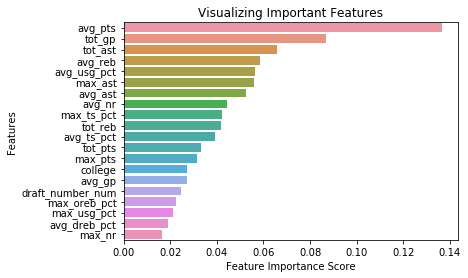

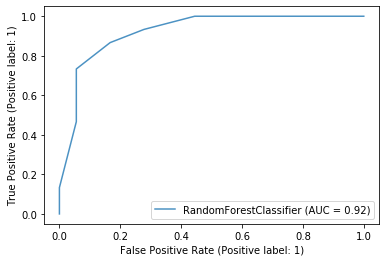

In [239]:
build_hof_rfc(master_df);

## Dropping all cumulative total statistics

In [240]:
non_tot_stats = []
for i in master_df.columns:
    if "tot_" not in i:
        non_tot_stats.append(i)

Model accuracy score: 0.9394


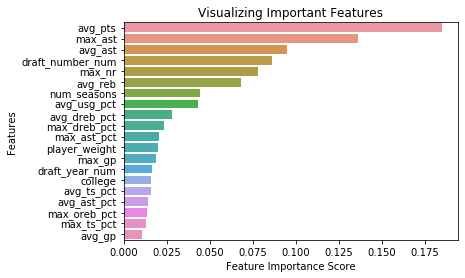

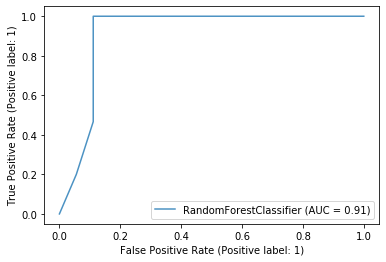

In [241]:
build_hof_rfc(master_df[non_tot_stats]);

## Using single decision tree 

In [242]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image 
import graphviz
import pydotplus

In [243]:
def build_hof_dtc(df, seed = 5):
    rus = RandomUnderSampler(random_state=seed)
    df_resampled, y_resampled = rus.fit_resample(df.drop(['hof_bin', 'player_name'], axis = 1), df['hof_bin'])
    
    X = df_resampled
    y = y_resampled
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = seed)
    
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    
    ax = plt.gca()
    dtc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax, alpha=0.8)
    plt.show()
    return clf

Model accuracy score: 0.7576


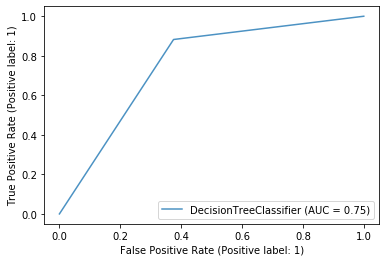

In [258]:
clf = build_hof_dtc(master_df, seed=10)

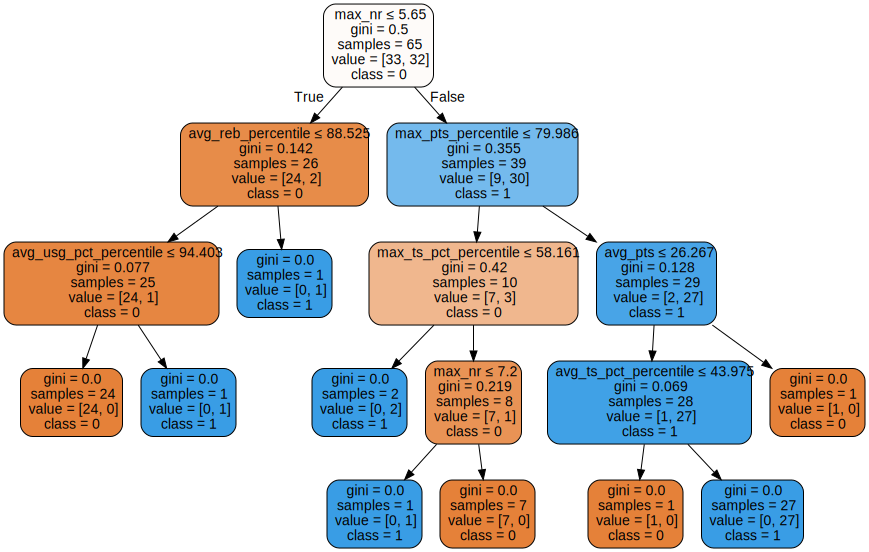

In [259]:
feature_names = master_df.drop(['hof_bin', 'player_name'], axis = 1).columns
dot_data = export_graphviz(clf, 
                  feature_names=feature_names,  
                  class_names=['0','1'],  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph

# Multiple Iterations

## all features

In [246]:
avg_acc = 0
fi = []
avg_auc = 0
iterations = 100

for seed in range(0, iterations):
    acc, feature_importance, auc = build_hof_rfc(master_df, seed, visual = False)
    avg_acc += acc
    fi.append(feature_importance)
    avg_auc += auc
avg_acc /= iterations
avg_fi = np.divide(np.sum(fi, axis = 0), iterations)
avg_auc /= iterations

Model accuracy score: 0.8291
Model auc score: 0.8912


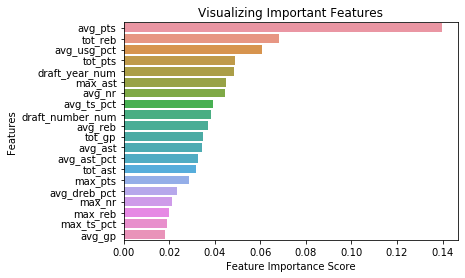

In [247]:
print('Model accuracy score: {0:0.4f}'.format(avg_acc))
print('Model auc score: {0:0.4f}'.format(avg_auc))
feature_scores = pd.Series(avg_fi, index=master_df.drop(['hof_bin', 'player_name'], axis = 1).columns).sort_values(ascending=False)
sns.barplot(x=feature_scores[0:20], y=feature_scores[0:20].index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Non-cumulative features

In [248]:
avg_acc = 0
fi = []
avg_auc = 0
iterations = 100

for seed in range(0, iterations):
    acc, feature_importance, auc = build_hof_rfc(master_df[non_tot_stats], seed, visual = False)
    avg_acc += acc
    fi.append(feature_importance)
    avg_auc += auc
avg_acc /= iterations
avg_fi = np.divide(np.sum(fi, axis = 0), iterations)
avg_auc /= iterations

Model accuracy score: 0.8303
Model auc score: 0.8966


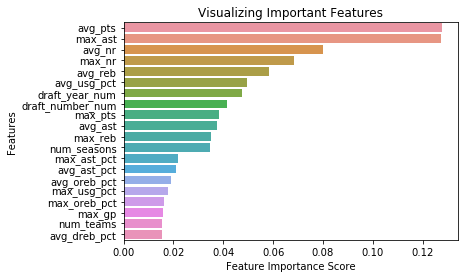

In [249]:
print('Model accuracy score: {0:0.4f}'.format(avg_acc))
print('Model auc score: {0:0.4f}'.format(avg_auc))
feature_scores = pd.Series(avg_fi, index=master_df[non_tot_stats].drop(['hof_bin', 'player_name'], axis = 1).columns).sort_values(ascending=False)
sns.barplot(x=feature_scores[0:20], y=feature_scores[0:20].index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

No matter if you're looking at an overall career or an ongoing career, the average points per season is the greatest predictor of a hall of fame (hof) player. Taking out cumulative statistics like "total (career) points," "total (career) assists," etc. reduces model performance by little.

Also interesting to note that awards like MVP's, final MVP's, college awards, are not important features - most likely due to the limited number of awards that can be handed out

# Feature engineering contextual statistics

One question I wanted to address is if contextual statistics are stronger predictors of HOF status. For example, in some eras of the NBA, points and assists were easier to come by. So perhaps points matter less in those eras and HOF status would reflect that era. I attempt to answer that question with percentile statistics grouped by season.

In [250]:
contextual_df = player_df.assign(pts_percentile=player_df.groupby("season")['pts'].rank(pct=True).mul(100))\
        .assign(reb_percentile=player_df.groupby("season")['reb'].rank(pct=True).mul(100))\
        .assign(ast_percentile=player_df.groupby("season")['ast'].rank(pct=True).mul(100))\
        .assign(net_rating_percentile=player_df.groupby("season")['net_rating'].rank(pct=True).mul(100))\
        .assign(oreb_pct_percentile=player_df.groupby("season")['oreb_pct'].rank(pct=True).mul(100))\
        .assign(dreb_pct_percentile=player_df.groupby("season")['dreb_pct'].rank(pct=True).mul(100))\
        .assign(usg_pct_percentile=player_df.groupby("season")['usg_pct'].rank(pct=True).mul(100))\
        .assign(ts_pct_percentile=player_df.groupby("season")['ts_pct'].rank(pct=True).mul(100))\
        .assign(ast_pct_percentile=player_df.groupby("season")['ast_pct'].rank(pct=True).mul(100))

In [251]:
contextual_df = duckdb.sql('''
    SELECT player_name AS pn, 
        AVG(pts_percentile) as avg_pts_percentile,
        MAX(pts_percentile) as max_pts_percentile,
        AVG(reb_percentile) as avg_reb_percentile,
        MAX(reb_percentile) as max_reb_percentile,
        AVG(ast_percentile) as avg_ast_percentile,
        MAX(ast_percentile) as max_ast_percentile,
        AVG(net_rating_percentile) as avg_net_rating_percentile,
        MAX(net_rating_percentile) as max_net_rating_percentile,
        AVG(oreb_pct_percentile) as avg_oreb_pct_percentile,
        MAX(oreb_pct_percentile) as max_oreb_pct_percentile,
        AVG(dreb_pct_percentile) as avg_dreb_pct_percentile,
        MAX(dreb_pct_percentile) as max_dreb_pct_percentile,
        AVG(usg_pct_percentile) as avg_usg_pct_percentile,
        MAX(usg_pct_percentile) as max_usg_pct_percentile,
        AVG(ts_pct_percentile) as avg_ts_pct_percentile,
        MAX(ts_pct_percentile) as max_ts_pct_percentile,
        AVG(ast_pct_percentile) as avg_ast_pct_percentile,
        MAX(ast_pct_percentile) as max_ast_pct_percentile,
    FROM contextual_df
    GROUP BY player_name
''')

In [252]:
master_df = duckdb.sql('''
    SELECT * 
    FROM master_df 
    LEFT JOIN contextual_df
    ON master_df.player_name = contextual_df.pn
''')

In [253]:
master_df = duckdb.sql('SELECT * FROM master_df').df()

In [254]:
master_df = master_df.drop(['pn'], axis = 1)

Model accuracy score: 0.8385
Model auc score: 0.9019


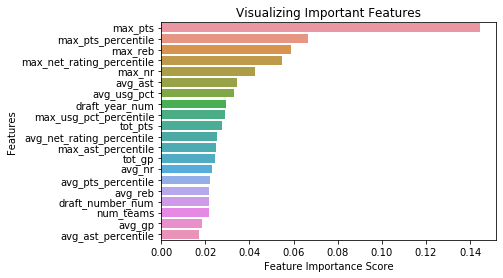

In [255]:
avg_acc = 0
fi = []
avg_auc = 0
iterations = 100

for seed in range(0, iterations):
    acc, feature_importance, auc = build_hof_rfc(master_df, seed, visual = False)
    avg_acc += acc
    fi.append(feature_importance)
    avg_auc += auc
avg_acc /= iterations
avg_fi = np.divide(np.sum(fi, axis = 0), iterations)
avg_auc /= iterations

print('Model accuracy score: {0:0.4f}'.format(avg_acc))
print('Model auc score: {0:0.4f}'.format(avg_auc))
feature_scores = pd.Series(avg_fi, index=master_df.drop(['hof_bin', 'player_name'], axis = 1).columns).sort_values(ascending=False)
sns.barplot(x=feature_scores[0:20], y=feature_scores[0:20].index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Non-cumulative statistics 

In [256]:
non_tot_stats = []
for i in master_df.columns:
    if "tot_" not in i:
        non_tot_stats.append(i)

Model accuracy score: 0.8433
Model auc score: 0.9011


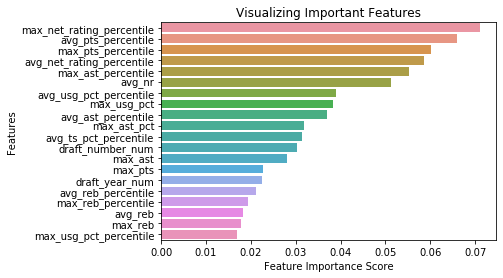

In [269]:
avg_acc = 0
fi = []
avg_auc = 0
iterations = 100

for seed in range(0, iterations):
    acc, feature_importance, auc, probs = build_hof_rfc(master_df[non_tot_stats], seed, visual = False)
    avg_acc += acc
    fi.append(feature_importance)
    avg_auc += auc
avg_acc /= iterations
avg_fi = np.divide(np.sum(fi, axis = 0), iterations)
avg_auc /= iterations

print('Model accuracy score: {0:0.4f}'.format(avg_acc))
print('Model auc score: {0:0.4f}'.format(avg_auc))
feature_scores = pd.Series(avg_fi, index=master_df[non_tot_stats].drop(['hof_bin', 'player_name'], axis = 1).columns).sort_values(ascending=False)
sns.barplot(x=feature_scores[0:20], y=feature_scores[0:20].index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Feature engineering these "contextual statistics" improves model performance by very little. But it's interesting to note that these contextual statistics do become important in our random forest models. Although they bring in redundancy, essentially acting as a proxy for the statistic they're contextualizing (i.e. a player in the top points percentile will also have a high points output), perhaps they relay some extra data to the model that make it more useful.

# Predicting Future Hall of Famers

In [291]:
test_set = pd.merge(player_df[player_df['season'] == '2022-23'][['player_name']],
         master_df[non_tot_stats], left_on='player_name', right_on='player_name', how='inner')
X_test = test_set.drop(['player_name', 'hof_bin'], axis = 1)

In [292]:
preds = []
iterations = 100

for seed in range(0, iterations):
    rfc = build_hof_rfc(master_df[non_tot_stats], seed, visual = False)[3]
    preds.append(rfc.predict_proba(X_test)[:, 1])
avg_preds = np.divide(np.sum(preds, axis = 0), iterations)

In [302]:
test_set['hof_prob'] = avg_preds
test_set[['player_name', 'hof_prob']].sort_values(by=['hof_prob'], ascending=False).head(20)

,player_name,hof_prob
269,Blake Griffin,0.938
428,LeBron James,0.934
10,Paul George,0.911
215,Giannis Antetokounmpo,0.909
326,Chris Paul,0.904
534,Joel Embiid,0.897
387,Kawhi Leonard,0.890
358,Kevin Durant,0.886
18,Russell Westbrook,0.880
291,Al Horford,0.878


## Blake Griffin over Lebron James. Makes sense to me